# Imports required

In [1]:
import subprocess, os, re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get all reports

In [2]:
def retrieve_data_from_github():
  localfolder = os.getcwd() # keep track of local folder
  os.chdir("C:\\Users\\ckumsta\\Documents\\GitHub\\Globalscan6-Plugin")
  cmd=['git','log','origin/master','--merges','--first-parent','--date-order','--shortstat','--pretty=format:"%cs %s"']
  result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE).stdout.decode('utf-8')
  os.chdir(localfolder)     # move back to local folder
  with open("repo_data.txt", "w") as f:
    f.write(result)

if not os.path.exists("repo_data.txt"):
  retrieve_data_from_github()

with open("repo_data.txt", "r") as f:
  result = f.read()

# Convertion into Pandas Dataframe

In [3]:
results = result.split(sep='\n\n')
print(results[1]) # to get an idea of data composition

"2023-08-01 *MINOR* #1990 G7StoneFruits, Speed up open stone defect"
 1 file changed, 5 insertions(+), 19 deletions(-)


In [4]:
# lets look for information types
month_names = ["Jan","Feb","Mar","Apr","May","Jun","July","Aug","Sept","Oct","Nov","Dec"]
cat_months = pd.CategoricalDtype(categories=month_names, ordered=True)
headers=["year","month","level","hash","subject","fruit","lines_modified"]
years=[]
months=[]
levels=[]
hashes=[]
subjects=[]
fruits=[]
lines_modified=[]
# create regex for informations
reg_description = re.compile(r"(?P<year>\d+)-(?P<month>\d+)-(?P<day>\d+)( )+(\*)?(?P<level>[\w ]+)(\*)?( )+#(?P<hash>\d+)( )?(?P<fruit>\w+)")

good_entries=0
bad_entries=0

#for item in results[1:2]:
for item in results[:-1]: # we skip the very first merge which is code creation
    try:
      lines = item.split('\n') # split the item into 2 lines, we want to process the second line only

      if "Merge pull request" in lines[0]:
         #print("UNFORMATTED --> UNUSABLE merge entry")
         bad_entries += 1
         continue

      subject = None
      for line in lines:
        description = reg_description.search(line)
        if description:
          year = description.group('year')
          month = month_names[int(description.group('month'))-1]
          level = description.group('level')
          hash = description.group('hash')
          fruit = description.group('fruit').lower()
          if "cherry" in fruit and "tomato" not in fruit:
            fruit="cherry"
          elif "cherry" in fruit:
            fruit="cherrytomato"
          elif "tomat" in fruit:
            fruit="tomato"
          elif "stone" in fruit:
            fruit="stonefruits"
          elif "lemon" in fruit:
            fruit="lemon"
          elif "orange" in fruit:
            fruit="orange"
          else:
            fruit="unknown"
          subject = line     
      if subject == None:
         #print("MALFORMATTED")
         bad_entries += 1
         continue # this item is malformatted and cannot be processed for the stats

      # retrieve insertions, deletion
      modifications_types = [ v.strip() for v in lines[-1].split(',')]
      modifications_types = [ re.search(r"(\d+) (.*)", v) for v in modifications_types]
      modifications = 0
      for modif_type in modifications_types:
        if not modif_type:
          raise Exception(f"What is this line: \"{lines[-1]}\"")
        if "file" not in modif_type.group(2):
           modifications += int(modif_type.group(1))
      
      # finally write down all elements of this entry
      years.append(year)
      months.append(month)
      levels.append(level)
      hashes.append(hash)
      subjects.append(subject)
      fruits.append(fruit)
      lines_modified.append(modifications)
      good_entries += 1
    except Exception as e:
       print("ERROR", e)
       print(item)
df = pd.DataFrame({"year": years, "month": months, "level":levels, "hash": hashes, "fruit": fruits, "modified_lines": lines_modified, "subject": subjects})
df['month'] = df['month'].astype(cat_months)
print("Bad entries:", bad_entries)
print("Good entries:", good_entries)
df

Bad entries: 100
Good entries: 1159


,year,month,level,hash,fruit,modified_lines,subject
0,2023,Aug,MINOR,1993,unknown,1,"""2023-08-02 *MINOR* #1993 from MAF-AGROBOTIC/G..."
1,2023,Aug,MINOR,1990,stonefruits,24,"""2023-08-01 *MINOR* #1990 G7StoneFruits, Speed..."
2,2023,July,MAJOR,1989,stonefruits,93,"""2023-07-31 *MAJOR* #1989 G7StoneFruits add op..."
3,2023,July,MAJOR,1988,stonefruits,72,"""2023-07-28 *MAJOR* #1988 G7StoneFruits, add n..."
4,2023,July,MAJOR,1986,stonefruits,7,"""2023-07-26 *MAJOR* #1986 G7StoneFtruits, skip..."
...,...,...,...,...,...,...,...
1154,2016,Sept,MINOR,37,unknown,0,"""2016-09-02 *MINOR* #37 move to uEye v4.8"""
1155,2016,Sept,DEV,36,unknown,2202,"""2016-09-02 *DEV* #36 Implement some Asynchron..."
1156,2016,Aug,MINOR,33,unknown,192,"""2016-08-05 *MINOR* #33 from Fix-UnhandledExce..."
1157,2016,July,MAJOR,32,unknown,1454,"""2016-07-14 *MAJOR* #32 Update-Updgrader-and-S..."


In [5]:
df_year_month = df.groupby(["year","month"]).agg({"modified_lines": "sum"}).reset_index()
df_year_month

,year,month,modified_lines
0,2016,Jan,0
1,2016,Feb,0
2,2016,Mar,0
3,2016,Apr,0
4,2016,May,0
...,...,...,...
91,2023,Aug,25
92,2023,Sept,0
93,2023,Oct,0
94,2023,Nov,0


[Text(0.5, 1.0, 'LOC (lines of code) for Cherry plugin')]

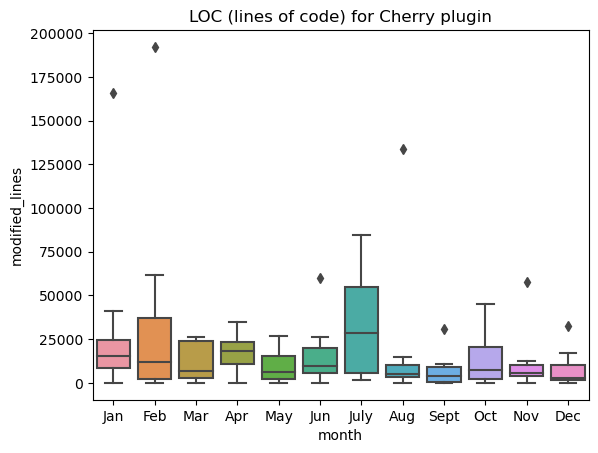

In [6]:
sns.boxplot(data=df_year_month, x="month", y="modified_lines").set(title="LOC (lines of code) for Cherry plugin")

[Text(0.5, 1.0, 'Median of LOC per month for Cherry')]

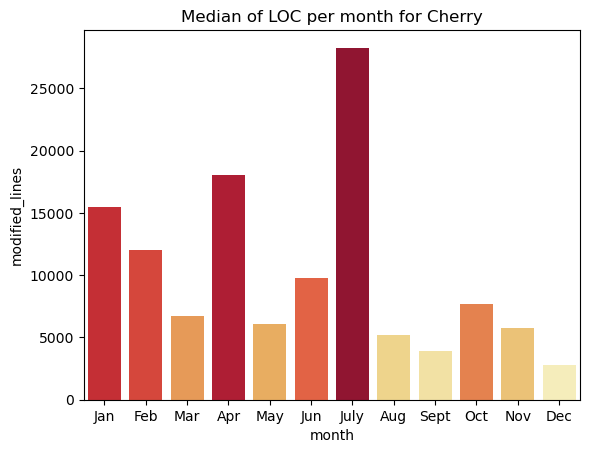

In [7]:
def colors_from_values(values: pd.Series, palette_name:str, ascending=True):
    '''Returns a seaborn palette reordered by value
    Parameters:
    values: pd.Series
    palette_name:str, Seaborn valid palette name
    ascending: bool, optional color sort order
    '''
    # convert to indices
    values = values.sort_values(ascending=ascending).reset_index()
    indices = values.sort_values(by=values.columns[0]).index
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)


df_month = df_year_month.groupby("month").agg({"modified_lines": "median"}).reset_index()
sns.barplot(data=df_month, x="month", y="modified_lines", palette=colors_from_values(df_month['modified_lines'],"YlOrRd")).set(title="Median of LOC per month for Cherry")

[Text(0.5, 1.0, 'commits per month for Cherry plugin')]

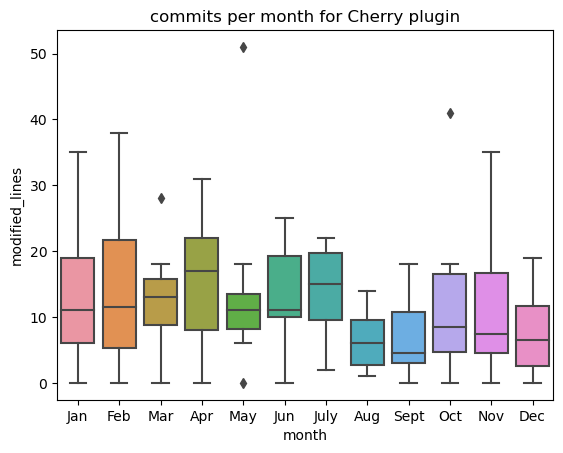

In [8]:
modif_count_per_year_month = df.groupby(["year","month"]).agg({"modified_lines": "count"}).reset_index()
sns.boxplot(data=modif_count_per_year_month, x="month", y="modified_lines").set(title="commits per month for Cherry plugin")

[Text(0.5, 1.0, 'Median commits per month for Cherry')]

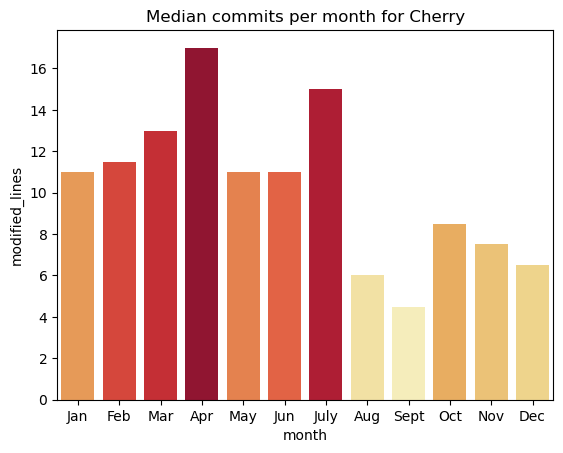

In [9]:
modif_count_per_month = modif_count_per_year_month.groupby("month").agg({"modified_lines": "median"}).reset_index()
sns.barplot(data=modif_count_per_month, x="month", y="modified_lines", palette=colors_from_values(modif_count_per_month['modified_lines'],"YlOrRd")).set(title="Median commits per month for Cherry")